# Set up

In [1]:
if (!require("xfun")) install.packages("xfun")

pkgs <- c(
  'urca', 'uroot', 'vars', 'forecast', 'dynlm', 'tsDyn',
  'lubridate', 'tsbox', 'timetk', 'xts', 'tsibble',
  'tidyverse', 'readr', 'vroom', 'readxl', 'writexl', 
  'rlist', 'here', 'forcats', "janitor",
  'extrafont', 'patchwork', 'hrbrthemes', 'ggthemes', 'ggsci', 'scales',
  'kableExtra', 'gt', 'reshape2'
)
xfun::pkg_attach2(pkgs, message = TRUE)

loadfonts(device = "win", quiet = TRUE)
setwd(here())

Loading required package: xfun


Attaching package: 'xfun'


The following objects are masked from 'package:base':

    attr, isFALSE


Loading required package: MASS

Loading required package: strucchange

Loading required package: zoo


Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric


Loading required package: sandwich

Loading required package: lmtest


Attaching package: 'lubridate'


The following objects are masked from 'package:base':

    date, intersect, setdiff, union



Attaching package: 'tsibble'


The following object is masked from 'package:lubridate':

    interval


The following object is masked from 'package:zoo':

    index


The following objects are masked from 'package:base':

    intersect, setdiff, union


-- Attaching packages ------------------------------------------------------------------------------- tidyverse 1.3.0 --

<U+221A> ggplot2 3.3.3     <U+221A> purrr   0.3.4
<U+221A> tibble  3.1.0 

In [2]:
# source("R/oaeTS.R", encoding = "UTF-8")
# year_now <- 2563

# Read data and Convert to long format

In [3]:
months_th <- c(
  'ม.ค.' = 1, 
  'ก.พ.' = 2, 
  'มี.ค.' = 3, 
  'เม.ย.'= 4, 
  'พ.ค.' = 5, 
  'มิ.ย.' = 6,
  'ก.ค.' = 7, 
  'ส.ค.' = 8, 
  'ก.ย.' = 9, 
  'ต.ค.' = 10, 
  'พ.ย.' = 11, 
  'ธ.ค.' = 12
)

## Farmgate price
รวมไฟล์ราคา แล้ว save เป็น RDS

In [4]:
read_price_rice_fg <- function(root, filename) {
  
  path = paste0(root, filename)
  sheets = excel_sheets(path)
  data = data.frame()

  for (i in sheets){
    dt =
      read_excel(path, skip=3, sheet=paste(i), na = c("-","",0)) %>%
      pivot_longer(-1, names_to='month_th', values_to='value') %>%
      filter(month_th %in% names(months_th)) %>%
      mutate(year = as.numeric(i) - 543) %>%
      mutate(month = months_th[month_th]) %>%
      mutate(date = as.Date(paste("1", 
                                  as.character(month), 
                                  as.character(year), 
                                  sep="/"),
                            format='%d/%m/%Y')
            )
      data = rbind(data, dt)
  }
  
  names(data)[1] = 'place'
  
  return(data)
}

In [5]:
root <- "data/rice/farmgate/"

rhfg <- read_price_rice_fg(root, "rhfg.xlsx") %>% mutate(price_id = 'RHFG')
rwfg <- read_price_rice_fg(root, "rwfg.xlsx") %>% mutate(price_id = 'RWFG')
rgfg <- read_price_rice_fg(root, "rgfg.xlsx") %>% mutate(price_id = 'RGFG')

rice_fg <- rbind(rhfg, rwfg, rgfg) %>%
  select(date, price_id, place, value) %>%
  filter(date < '2020-01-01')

# saveRDS(rice_fg, 'data/rice/rice_fg.rds')
rice_fg

date,price_id,place,value
<date>,<chr>,<chr>,<dbl>
1989-01-01,RHFG,เฉลี่ยทั้งประเทศ,4237
1989-02-01,RHFG,เฉลี่ยทั้งประเทศ,4331
1989-03-01,RHFG,เฉลี่ยทั้งประเทศ,4420
1989-04-01,RHFG,เฉลี่ยทั้งประเทศ,4506
1989-05-01,RHFG,เฉลี่ยทั้งประเทศ,4620
...,...,...,...
2019-08-01,RGFG,นครราชสีมา,12793
2019-09-01,RGFG,นครราชสีมา,15475
2019-10-01,RGFG,นครราชสีมา,14525


## Wholesale price
รวมไฟล์ราคา แล้ว save เป็น RDS

In [6]:
# define function
read_price_ws <- function(year, month) {

  path <- glue::glue("data/rice/wholesale/ws{year}.xls")
  read_excel(
    path, skip = 1, 
    sheet = month.abb[month] %>% tolower(), 
    na = c("-", "", 0)
  ) %>%
    suppressMessages() %>%
    rename_at(1:2, ~c("price_id", "price_name")) %>%
    pivot_longer(
      -(1:2), 
      names_to = 'day', 
      values_to = 'value'
    ) %>%
    filter(day %in% as.character(1:31)) %>%
    mutate(
      date = as.Date(glue::glue("{year-543}-{month}-{day}")),
      place = 'bangkok'
    ) %>%
    drop_na(value, date) %>%
    select(date, price_id, place, value)
}

# test
# year <- 2555
# month <- 1
# read_price_ws(year, month)

In [7]:
rice_ws <- expand_grid(
  year = 2547:2562, 
  month = 1:12
) %>% 
  pmap(read_price_ws) %>%
  reduce(bind_rows)

# saveRDS(rice_ws, 'data/rice/rice_ws.rds')

In [8]:
rice_ws

date,price_id,place,value
<date>,<chr>,<chr>,<dbl>
2004-01-02,RHWS00AO,bangkok,19000
2004-01-05,RHWS00AO,bangkok,19000
2004-01-06,RHWS00AO,bangkok,19000
2004-01-07,RHWS00AO,bangkok,19000
2004-01-08,RHWS00AO,bangkok,19600
...,...,...,...
2019-12-23,RPWSA1GU,bangkok,9350
2019-12-24,RPWSA1GU,bangkok,9350
2019-12-25,RPWSA1GU,bangkok,9350


## Export price
รวมไฟล์ราคา แล้ว save เป็น RDS

In [9]:
read_price_ex_th <- function(year, month) {
  
  first_day_of_month <- ymd(glue::glue("{year-543}-{month}-1"))
  last_day_of_month  <- first_day_of_month %>% ceiling_date(unit = "month") - 1
  d <- seq(first_day_of_month, by = 1, length.out = 7)
  d <- seq(d[wday(d)==6], by = 7, length.out = 5)
  d <- d[lubridate::month(d) == month]
  if(length(d) == 4) {
    d[5] <- last_day_of_month
  }
  
  path <- glue::glue("data/rice/export_th/ex{year}.xlsx")
  read_excel(
    path, skip = 2,
    sheet = month.abb[month] %>% tolower(), 
    na = c("-", "", 0)
  ) %>%
    suppressMessages() %>%
    rename_at(1:2, ~c("price_id", "price_name")) %>%
    select(1:7) %>%
    drop_na(price_id) %>%
    pivot_longer(
      -(1:2), 
      names_to = 'week', 
      values_to = 'value'
    ) %>%
    drop_na(value) %>%
    mutate(
      date = d[week %>% as.numeric],
      place = 'bangkok'
    ) %>%
    select(date, price_id, place, value)
}

# test
# year <- 2555
# month <- 1
# read_price_ex(year, month)

In [10]:
rice_ex_th <- expand_grid(
  year = 2547:2562, 
  month = 1:12
) %>% 
  pmap(read_price_ex_th) %>%
  reduce(bind_rows)

# saveRDS(rice_ex_th, 'data/rice/rice_ex_th.rds')

In [11]:
rice_ex_th

date,price_id,place,value
<date>,<chr>,<chr>,<dbl>
2004-01-02,RHXB00AO,bangkok,22303.25
2004-01-09,RHXB00AO,bangkok,22293.38
2004-01-16,RHXB00AO,bangkok,21810.25
2004-01-23,RHXB00AO,bangkok,22265.46
2004-01-02,RHXS00AO,bangkok,572.00
...,...,...,...
2019-12-13,RPXBA1GU,bangkok,10812.64
2019-12-20,RPXBA1GU,bangkok,10824.34
2019-12-06,RPXSA1GU,bangkok,360.00


## Combine prices from 3 markets

In [12]:
rice_price <- bind_rows(rice_fg, rice_ws, rice_ex_th)
# saveRDS(rice_price, 'data/rice/rice_price.rds')

In [13]:
rice_price

date,price_id,place,value
<date>,<chr>,<chr>,<dbl>
1989-01-01,RHFG,เฉลี่ยทั้งประเทศ,4237
1989-02-01,RHFG,เฉลี่ยทั้งประเทศ,4331
1989-03-01,RHFG,เฉลี่ยทั้งประเทศ,4420
1989-04-01,RHFG,เฉลี่ยทั้งประเทศ,4506
1989-05-01,RHFG,เฉลี่ยทั้งประเทศ,4620
...,...,...,...
2019-12-13,RPXBA1GU,bangkok,10812.64
2019-12-20,RPXBA1GU,bangkok,10824.34
2019-12-06,RPXSA1GU,bangkok,360.00


In [2]:
rice_price <- readRDS('data/rice/rice_price.rds')
rice_price

date,price_id,place,value
<date>,<chr>,<chr>,<dbl>
1989-01-01,RHFG,เฉลี่ยทั้งประเทศ,4237
1989-02-01,RHFG,เฉลี่ยทั้งประเทศ,4331
1989-03-01,RHFG,เฉลี่ยทั้งประเทศ,4420
1989-04-01,RHFG,เฉลี่ยทั้งประเทศ,4506
1989-05-01,RHFG,เฉลี่ยทั้งประเทศ,4620
...,...,...,...
2019-12-13,RPXBA1GU,bangkok,10812.64
2019-12-20,RPXBA1GU,bangkok,10824.34
2019-12-06,RPXSA1GU,bangkok,360.00


# Convert to wide format

In [3]:
prices_selected <- c(
  "RHFG",                 # hommali rice farmgate
  "RHWS00BO", "RHWS00BN", # hommali rice wholesale
  "RHXB00BO", "RHXB00BN", # hommali rice export in baht
  "RWFG",                 # white rice farmgate
  "RWWS05GN",             # white rice wholesale 
  "RWXB05GU"              # white rice export in baht
)

In [4]:
rice_price_wide <- rice_price %>%
  arrange(price_id) %>%
  filter(
    place %in% c("bangkok", "เฉลี่ยทั้งประเทศ"),
    price_id %in% prices_selected
  ) %>%
  pivot_wider(
    id = date,
    names_from = price_id,
    values_from = value
  ) %>% 
  arrange(date) #%>% write_xlsx("data/rice/rice_price_wide.xlsx")

In [5]:
rice_price_wide

date,RHFG,RHWS00BN,RHWS00BO,RHXB00BN,RHXB00BO,RWFG,RWWS05GN,RWXB05GU
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1989-01-01,4237,NA,NA,NA,NA,3939,NA,NA
1989-02-01,4331,NA,NA,NA,NA,4056,NA,NA
1989-03-01,4420,NA,NA,NA,NA,4135,NA,NA
1989-04-01,4506,NA,NA,NA,NA,4249,NA,NA
1989-05-01,4620,NA,NA,NA,NA,4450,NA,NA
...,...,...,...,...,...,...,...,...
2019-12-23,NA,30550,31550,NA,NA,NA,11650,NA
2019-12-24,NA,30550,31550,NA,NA,NA,11850,NA
2019-12-25,NA,30550,31550,NA,NA,NA,11850,NA


# Convert to monthly

In [6]:
rice_price_wide_m <- rice_price_wide %>%
  mutate(
    date_floor = floor_date(date, unit = "month")
  ) %>%
  group_by(date_floor) %>%
  summarize(across(starts_with("R"), ~ mean(.x, na.rm = TRUE)))

rice_price_wide_m
# rice_price_wide_m %>% write_xlsx("data/rice/rice_price_wide_m.xlsx")

date_floor,RHFG,RHWS00BN,RHWS00BO,RHXB00BN,RHXB00BO,RWFG,RWWS05GN,RWXB05GU
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1989-01-01,4237,NaN,NaN,NaN,NaN,3939,NaN,NaN
1989-02-01,4331,NaN,NaN,NaN,NaN,4056,NaN,NaN
1989-03-01,4420,NaN,NaN,NaN,NaN,4135,NaN,NaN
1989-04-01,4506,NaN,NaN,NaN,NaN,4249,NaN,NaN
1989-05-01,4620,NaN,NaN,NaN,NaN,4450,NaN,NaN
...,...,...,...,...,...,...,...,...
2019-08-01,16035,33364.29,34364.29,36817.24,36955.21,7897,11764.29,13111.66
2019-09-01,16562,34640.48,36111.90,37540.59,36896.64,7827,11550.00,12889.96
2019-10-01,16291,34650.00,36550.00,36691.71,36965.13,7921,11402.38,12731.47


# Clean

In [7]:
rice_price_wide_m_clean <- rice_price_wide_m %>%
  mutate(
    phf = RHFG,
    phw = ifelse(is.na(RHWS00BN), RHWS00BO, RHWS00BN),
    phx = ifelse(is.na(RHXB00BN), RHXB00BO, RHXB00BN),
    pwf = RWFG,
    pww = RWWS05GN,
    pwx = RWXB05GU
  ) %>%
  select(c("date" = date_floor), starts_with("p"))

In [8]:
rice_price_wide_m_clean

date,phf,phw,phx,pwf,pww,pwx
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1989-01-01,4237,NaN,NaN,3939,NaN,NaN
1989-02-01,4331,NaN,NaN,4056,NaN,NaN
1989-03-01,4420,NaN,NaN,4135,NaN,NaN
1989-04-01,4506,NaN,NaN,4249,NaN,NaN
1989-05-01,4620,NaN,NaN,4450,NaN,NaN
...,...,...,...,...,...,...
2019-08-01,16035,33364.29,36817.24,7897,11764.29,13111.66
2019-09-01,16562,34640.48,37540.59,7827,11550.00,12889.96
2019-10-01,16291,34650.00,36691.71,7921,11402.38,12731.47


# Add dummy variables

In [9]:
# dummy years ช่วงวิกฤตอาหารครั้งที่ 1
start_foodcrisis <- ymd('2007-11-01')
end_foodcrisis   <- ymd('2008-06-01')

# dummy years ช่วงนโยบายจำนำข้าวทุกเมล็ดของ นายก ยิ่งลักษณ์
start_pledge <- ymd('2011-09-01')
end_pledge   <- ymd('2014-01-01')

In [10]:
rice_price_wide_m_clean <- rice_price_wide_m_clean %>%
  mutate(
    d_foodcrisis = ifelse(
      date >= start_foodcrisis & date <= end_foodcrisis, 1, 0),
    d_pledge = ifelse(
      date >= start_pledge & date <= end_pledge, 1, 0)
  )

rice_price_wide_m_clean
# rice_price_wide

date,phf,phw,phx,pwf,pww,pwx,d_foodcrisis,d_pledge
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1989-01-01,4237,NaN,NaN,3939,NaN,NaN,0,0
1989-02-01,4331,NaN,NaN,4056,NaN,NaN,0,0
1989-03-01,4420,NaN,NaN,4135,NaN,NaN,0,0
1989-04-01,4506,NaN,NaN,4249,NaN,NaN,0,0
1989-05-01,4620,NaN,NaN,4450,NaN,NaN,0,0
...,...,...,...,...,...,...,...,...
2019-08-01,16035,33364.29,36817.24,7897,11764.29,13111.66,0,0
2019-09-01,16562,34640.48,37540.59,7827,11550.00,12889.96,0,0
2019-10-01,16291,34650.00,36691.71,7921,11402.38,12731.47,0,0


In [11]:
saveRDS(rice_price_wide_m_clean, 'data/rice/clean/rice_price.rds')
write_xlsx(rice_price_wide_m_clean, 'data/rice/clean/rice_price.xlsx')

In [30]:
options(repr.plot.bg = "grey80")

# กราฟ

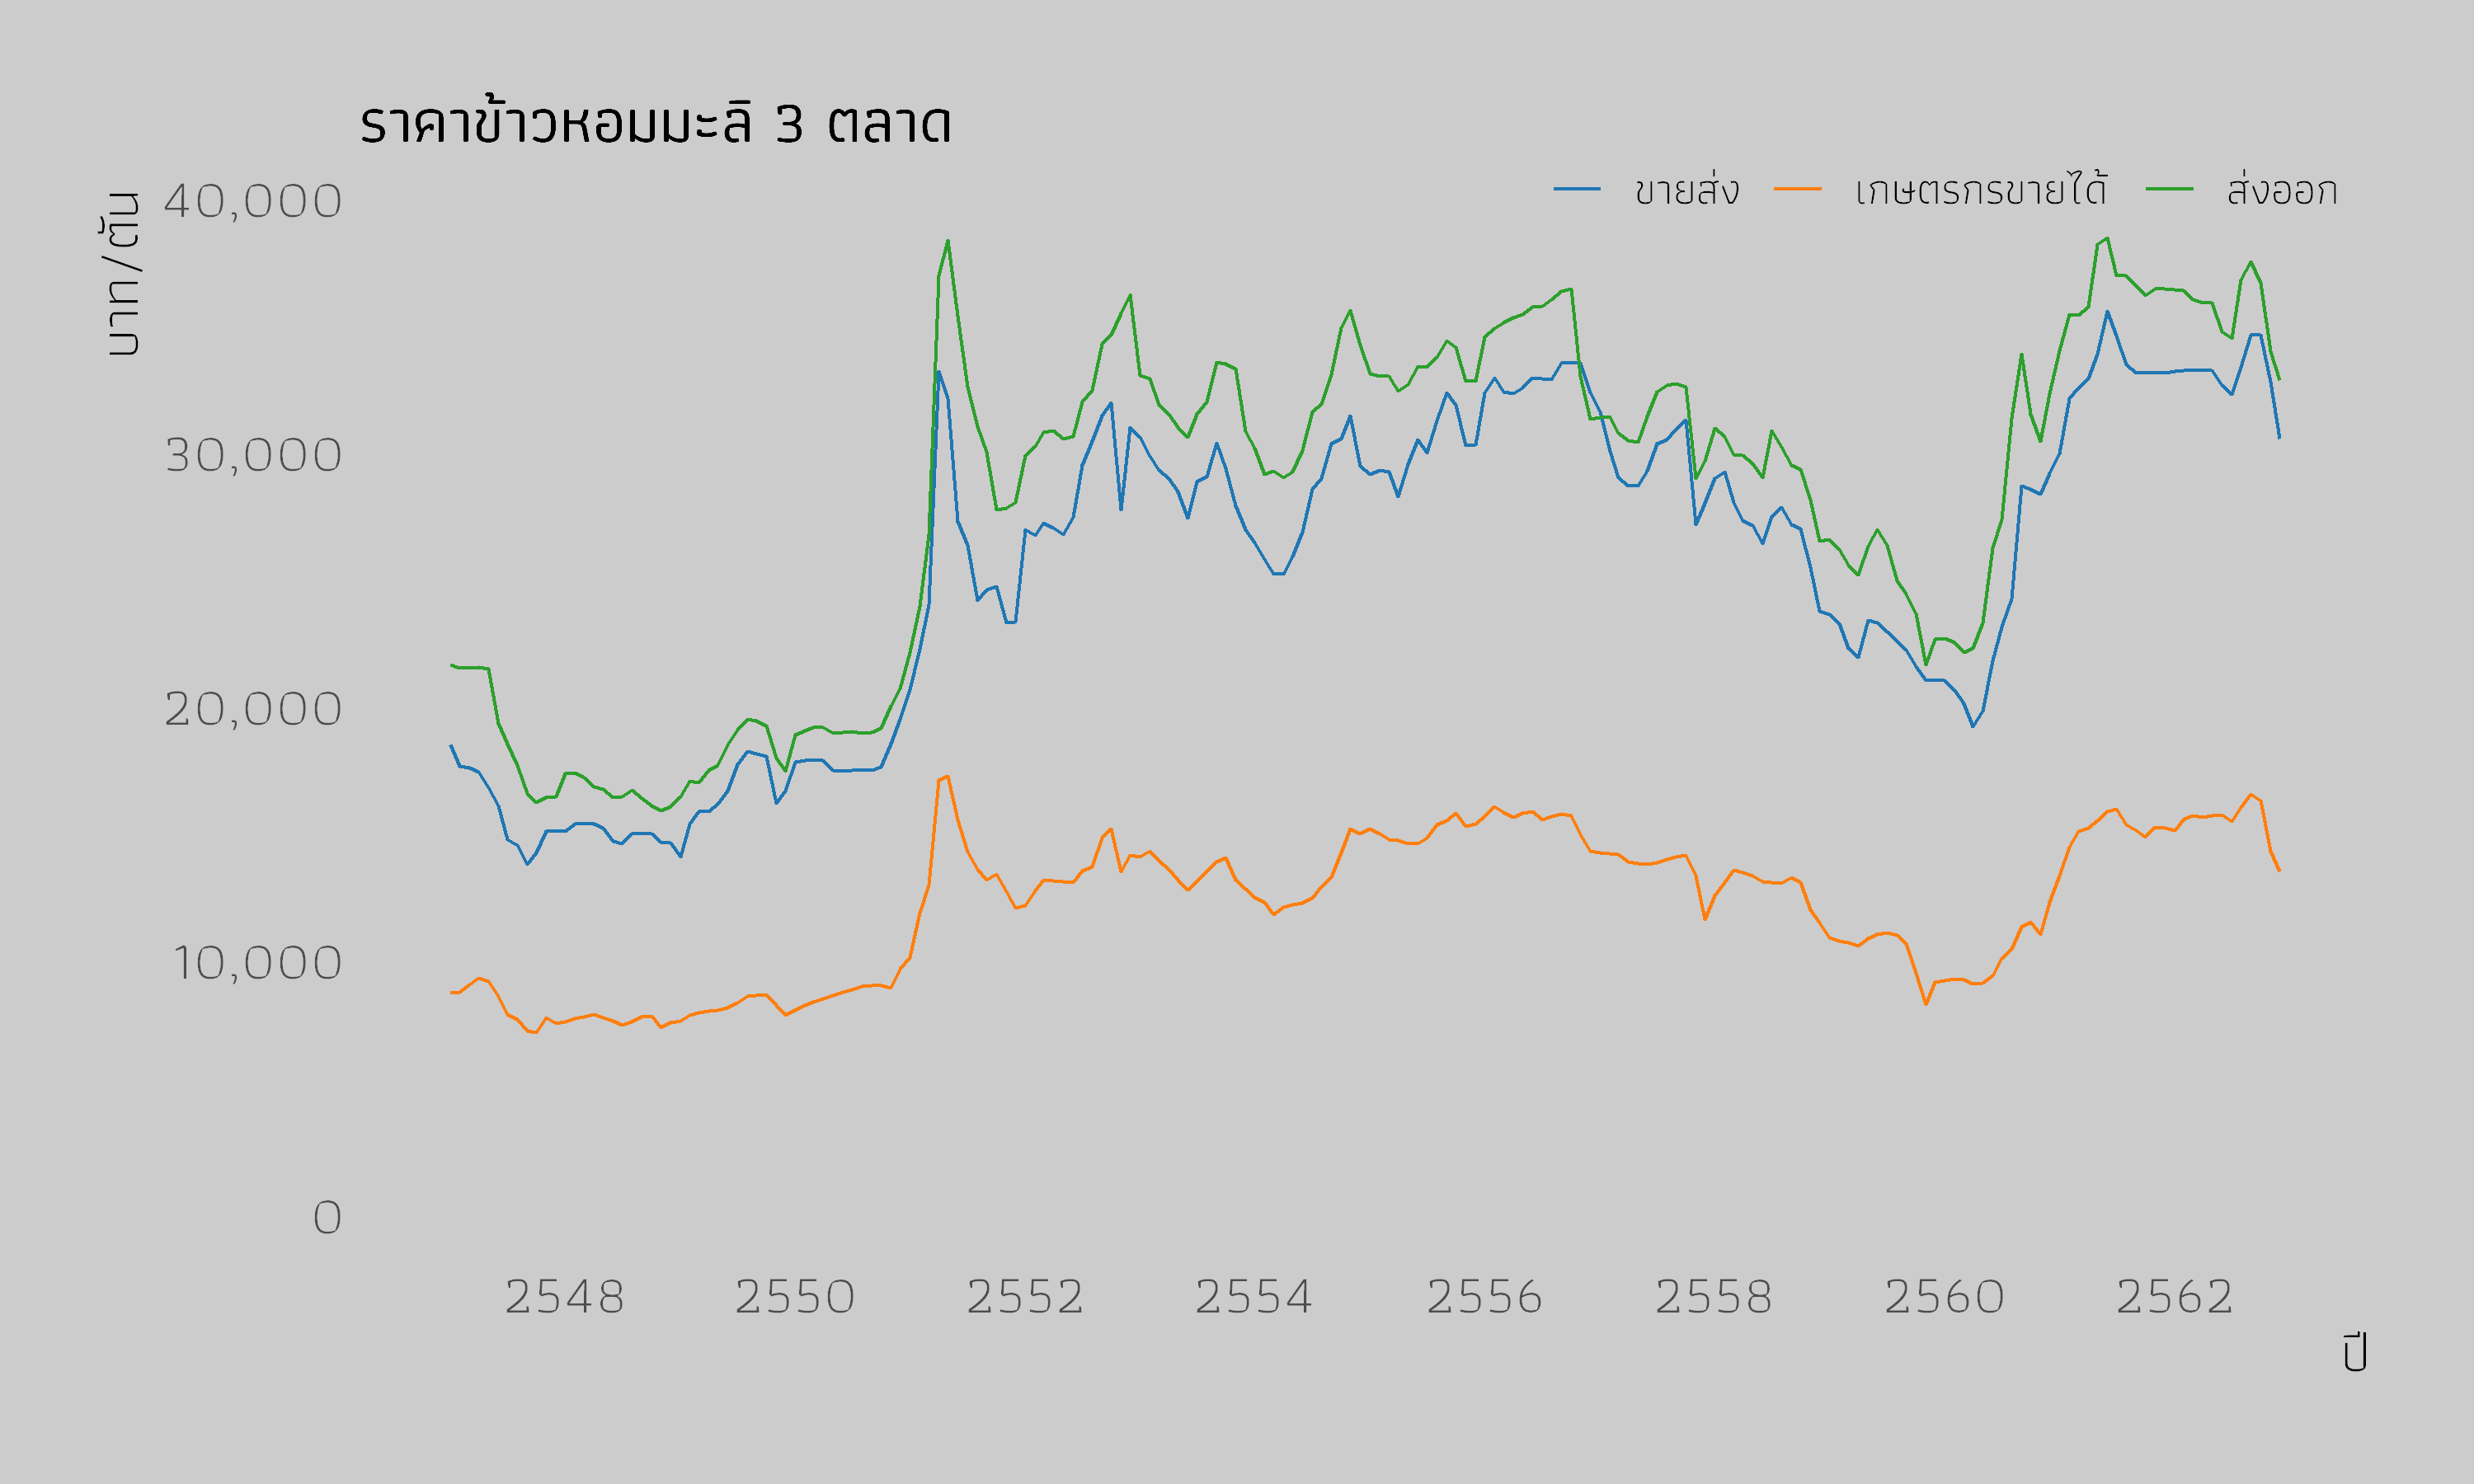

In [31]:
rice_price_wide_m_clean %>% filter(date >= '2004-01-01') %>%
  ggplot(aes(x=date)) +
    geom_line( aes(y=phf, color = 'เกษตรกรขายได้')) +
    geom_line( aes(y=phw, color = 'ขายส่ง')) +
    geom_line( aes(y=phx, color = 'ส่งออก')) +
    scale_color_d3() +
    expand_limits(y = 0) +
    scale_y_continuous(label = comma) +
    labs(title = 'ราคาข้าวหอมมะลิ 3 ตลาด',
         x =  "ปี",
         y = 'บาท/ตัน'
        ) +
    theme_ipsum(
      base_size = 16,
      base_family = "Athiti Light",
      axis_title_size = 16
    ) + 
    theme(
      legend.position = c(1, 1),
      legend.direction = 'horizontal',
      legend.justification = 'right',
      legend.title = element_blank(),
      panel.grid.major = element_blank(), 
      panel.grid.minor = element_blank(),
      panel.background = element_rect(fill = "transparent",colour = NA),
      plot.background = element_rect(fill = "transparent",colour = NA)
    ) +
    scale_x_date(date_breaks = '2 years',
                 labels = function(x) year(x)+543
                 )

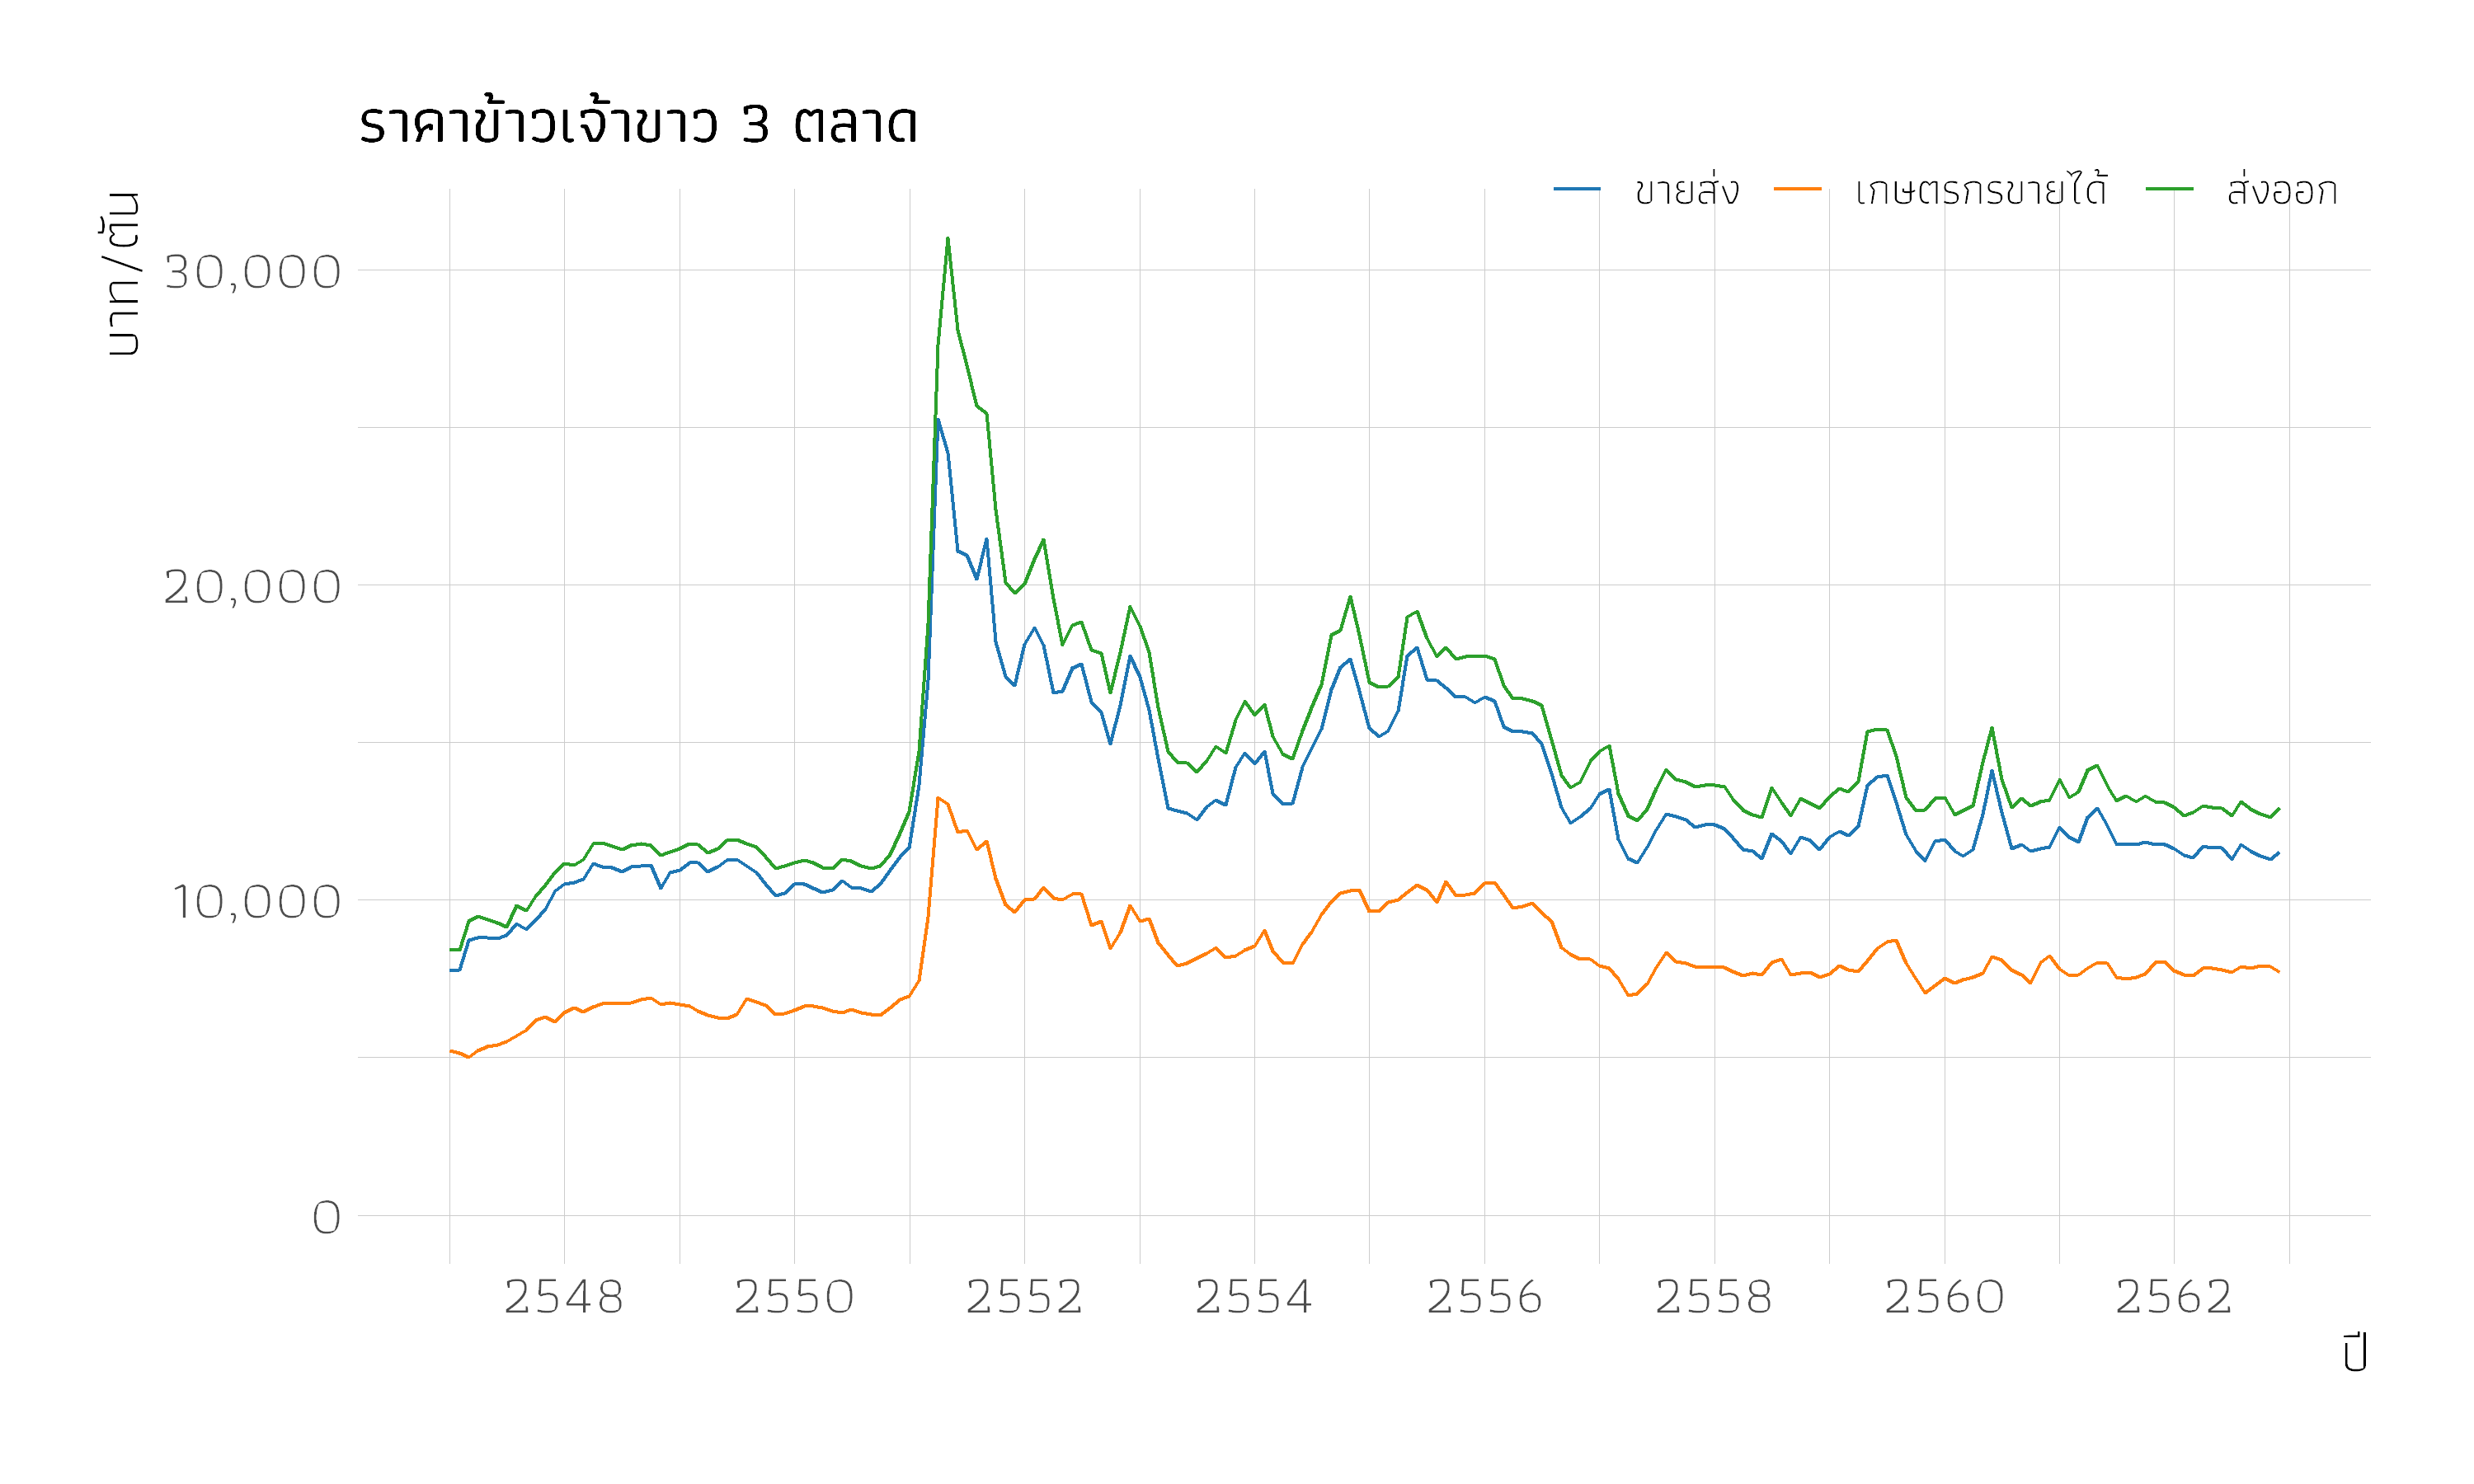

In [32]:
rice_price_wide_m_clean %>% filter(date >= '2004-01-01') %>%
  ggplot(aes(x=date)) +
    geom_line( aes(y=pwf, color = 'เกษตรกรขายได้')) +
    geom_line( aes(y=pww, color = 'ขายส่ง')) +
    geom_line( aes(y=pwx, color = 'ส่งออก')) +
    scale_color_d3() +
    expand_limits(y = 0) +
    scale_y_continuous(label = comma) +
    labs(title = 'ราคาข้าวเจ้าขาว 3 ตลาด',
         x =  "ปี",
         y = 'บาท/ตัน'
        ) +
    theme_ipsum(
      base_size = 16,
      base_family = "Athiti Light",
      axis_title_size = 16
    ) +
    theme(
      legend.position = c(1, 1),
      legend.direction = 'horizontal',
      legend.justification = 'right',
      legend.title = element_blank()
    ) +
    scale_x_date(date_breaks = '2 years',
                 labels = function(x) year(x)+543
                 )

# Backup

In [ ]:
# rice_fg_wide = rice_price %>%
#   filter(grepl('FG', price_id)) %>%
#   filter(!is.na(amount)) %>%
#   filter(!is.na(date)) %>%
#   left_join(tbl_admin_tha1, by=c("place" = "name_oae1")) %>%
#   mutate(place_id = str_replace_all(HASC_1, "TH.", "")) %>%
#   mutate(new_price_id=paste(price_id, place_id, sep="_")) %>%
#   mutate(month = floor_date(date, "month")) %>%
#   filter(new_price_id %in% prices) %>%
#   select(month, place, new_price_id, amount) %>%
#   group_by(month, new_price_id) %>%
#   summarise(amount = mean(amount)) %>%
#   spread(new_price_id, amount)

# write.xlsx(rice_price_wide, '../data/rice/rice_price_wide.xlsx')

In [ ]:
# prices = c("RHWS00BO", "RHWS00BN", # hommali rice wholesale
#            "RHXB00BO", "RHXB00BN", # hommali rice export
#            "RWWS05GO", "RWWS05GN", # white rice wholesale 
#            "RWXB05GU", # white rice export 
#            "RGWS10LO", "RGWS10LN", # glutinous wholesale
#            "RGXB10GF", "RGXB10GS", "RGXB10GU", "RGXB10LU" # glutinous export
#           )

# rice_price_wide = rice_price %>%
#     select(-place) %>%
#     filter(price_id %in% prices) %>%
#     filter(!is.na(date)) %>%
#     mutate(month = floor_date(date, "month")) %>%
#     mutate(new_price_id = substr(price_id,start = 1, stop = 4)) %>%
#     group_by(month, new_price_id) %>%
#     summarise(amount = mean(amount)) %>%
#     spread(new_price_id, amount) %>%
#     right_join(rice_fg_wide, by="month")

In [ ]:
# check <- rice_price %>%
#     filter(grepl('FG', price_id)) %>%
#     mutate(count = !is.na(amount)) %>%
#     group_by(place, price_id) %>%
#     summarise(sum = sum(count)) %>%
#     spread(price_id, sum)

# write.xlsx(check, '../data/rice/check.xlsx')

In [ ]:
# library(rio)
# data_list <- import_list("../data/data_dict.xlsx")

# A <- data_list$aa['aa']
# B <- data_list$bb['bb']
# C <- data_list$cc['cc']
# D <- data_list$d['d']
# E <- data_list$e['e']

# price_id_names <- unique(rice_price$price_id)

# tbl_rice_price <- crossing(A,B,C,D,E) %>% 
#     mutate(price_id = pmap_chr(., paste, sep="")) %>%
#     mutate(price_id = str_replace_all(price_id, "Z", "")) %>%
#     filter(price_id %in% price_id_names)

# tbl_rice_price <- tbl_price_rice %>%
#     left_join(data_list$aa) %>%
#     left_join(data_list$bb) %>%
#     left_join(data_list$cc) %>%
#     left_join(data_list$d) %>%
#     left_join(data_list$e) %>%
#     unite(price_name, c(aa_name, bb_name, cc_name, d_name, e_name), sep = " ", remove = FALSE) %>%
#     unite(price_name_th, c(aa_name_th, bb_name_th, cc_name_th, d_name_th, e_name_th), sep = " ", remove = FALSE) %>%
#     mutate(price_name = str_replace_all(price_name, "NA", "")) %>% 
#     mutate(price_name_th = str_replace_all(price_name_th, "NA", ""))

# write.xlsx(tbl_rice_price, '../data/rice/tbl_rice_price.xlsx')

In [ ]:
# count_by_price_id <- rice_price %>%
#     group_by(price_id) %>%
#     summarize(sum(!is.na(amount))) %>%
#     left_join(tbl_rice_price)
# write.xlsx(count_by_price_id, '../data/rice/count_by_price_id.xlsx')

In [ ]:
# write.xlsx(unique(rice_fg$place), 'changwat.xlsx')

In [ ]:
# tbl_admin_tha1 <- read_excel("data/tbl_admin_tha1.xlsx")
# tbl_admin_tha1

# prices = c("RGFG_0", #"RGFG_1", "RGFG_2", "RGFG_3",
#            "RGFG_KK", "RGFG_SN", "RGFG_UN", "RGFG_KL", "RGFG_MS",
#            "RHFG_0", #"RHFG_1", "RHFG_2", "RHFG_3", 
#            "RHFG_SU", "RHFG_NR", "RHFG_UR", "RHFG_SI", "RHFG_BR",
#            "RWFG_0", #"RWFG_1", "RWFG_2", "RWFG_3", 
#            "RWFG_NS", "RWFG_PC", "RWFG_KP", "RWFG_SH", "RWFG_PS"
#           )

# rice_fg_wide = rice_price %>%
#   filter(endsWith(price_id, "FG")) %>%
#   mutate(HASC_1 = sapply(place,
#                          lookup,
#                          tbl_admin_tha1, 
#                          key = 'name_th1', 
#                          alt = 'name_alt',
#                          val = 'HASC_1',
#                          simplify = TRUE)
#         ) %>%
#   left_join(tbl_admin_tha1, by=c('HASC_1')) %>%
#   mutate(place_id = str_replace_all(HASC_1, "TH.", "")) %>%
#   mutate(price_id = paste(price_id, place_id, sep="_")) %>%
#   mutate(date = floor_date(date, "month")) %>%
#   filter(price_id %in% prices) %>%
#   pivot_wider(id_cols = date,
#               names_from = price_id,
#               values_from = amount,
#               values_fn = list(amount = mean)
#              )

# rice_fg_wide

In [ ]:
# prices = c("RHWS00BO", "RHWS00BN", # hommali rice wholesale
#            "RHXB00BO", "RHXB00BN", # hommali rice export
#            "RWWS05GO", "RWWS05GN", # white rice wholesale 
#            "RWXB05GU", # white rice export 
#            "RGWS10LO", "RGWS10LN", # glutinous wholesale
#            "RGXB10GF", "RGXB10GS", "RGXB10GU", "RGXB10LU" # glutinous export
#           )

# rice_price_wide = rice_price %>%
#   select(-place) %>%
#   filter(price_id %in% prices) %>%
#   filter(!is.na(date)) %>% # there are some missing date due to week
#   mutate(date = floor_date(date, "month")) %>%
#   mutate(price_id = substr(price_id, start = 1, stop = 4)) %>%
#   pivot_wider(id_cols = date,
#               names_from = price_id,
#               values_from = amount,
#               values_fn = list(amount = mean)
#              )

# rice_price_wide = rice_fg_wide %>% left_join(rice_price_wide, by="date")
# rice_price_wide